In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time

import os, sys
import time
import pandas as pd
import matplotlib.pyplot as plt
# Add the parent directory (one level up) to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

import pipeline

In [68]:
from modules.adaptive.filters.collaborative import CollaborativeFiltering
from modules.personalization.recommender import Recommender
from surprise import SVD

In [69]:
from sklearn.metrics import mean_squared_error

In [70]:
svd_params = {
    'n_factors': 200,
    'n_epochs': 100,
    'lr_all': 0.01,
    'reg_all': 0.1
}
model = CollaborativeFiltering(
    algorithm=SVD(**svd_params),
    ratings_file='../storage/u.data_train_temp',
    metadata_file='../storage/u.item'
)
model.fit()

recommender = Recommender(model=model)
# rankings = recommender.rank_items(user_id=196, top_n=10)
# print(rankings)

In [71]:
from modules.collaborative_filtering import CollaborativeFiltering
import pipeline
#load the dataset
pline = pipeline.Pipeline()
cols = ['user', 'item', 'rating', 'timestamp']
df = pline.load_dataset('../storage/u.data_train_temp', column_names = cols)

In [72]:
#evaluate using the test set
# trs = []
# prs = []
baseline_rmses = []
for _, row in df.iterrows():
    user_id, item_id, true_rating = row['user'], row['item'], row['rating']
    try:
        predicted_rating = model.predict(user_id, item_id)
        # trs.append(true_rating)
        # prs.append(predicted_rating)
        baseline_rmse = np.sqrt(np.abs(true_rating - predicted_rating))
        baseline_rmses.append(baseline_rmse)
    except:
        pass

In [73]:
#production rmse
# baseline_rmse = np.sqrt(mean_squared_error(trs, prs))

In [74]:
df_test = pline.load_dataset('../storage/u.data_test_temp', column_names = cols)
#evaluate using the test set
# trs = []
# prs = []
production_rmses = []
for _, row in df_test.iterrows():
    user_id, item_id, true_rating = row['user'], row['item'], row['rating']
    try:
        predicted_rating = model.predict(user_id, item_id)
        # trs.append(true_rating)
        # prs.append(predicted_rating)
        production_rmse = np.sqrt(np.abs(true_rating - predicted_rating))
        production_rmses.append(production_rmse)
    except:
        pass
# #production rmse
# production_rmse = np.sqrt(mean_squared_error(trs, prs))

In [82]:
from modules.adaptive.continuous_learning import ContinuousLearner

learner = ContinuousLearner(baseline_rmse=baseline_rmses)
retrain, pvalue = learner.detect_drift(production_rmses, return_pvalue = True)

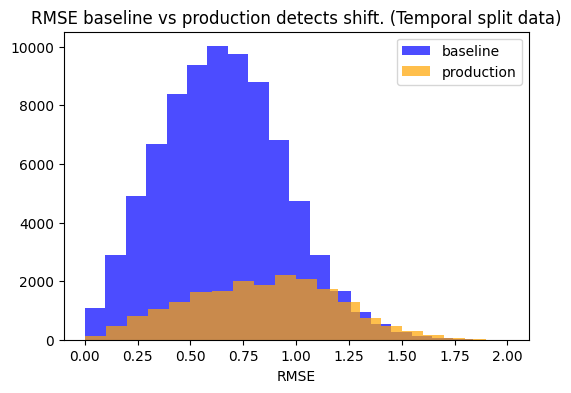

In [87]:
# Plot histograms
plt.figure(figsize = (6, 4))
plt.hist(baseline_rmses, color='blue', label='baseline', alpha=0.7, bins = 20)
plt.hist(production_rmses, color='orange', label='production', alpha=0.7, bins = 20)
plt.xlabel('RMSE')
plt.legend()
plt.title('RMSE baseline vs production detects shift. (Temporal split data)')
plt.show()

In [90]:
#rerankting
from modules.adaptive.filters.collaborative import CollaborativeFiltering
from surprise import SVD

svd_params = {
    'n_factors': 200,
    'n_epochs': 100,
    'lr_all': 0.01,
    'reg_all': 0.1
}
model = CollaborativeFiltering(
    algorithm=SVD(**svd_params),
    ratings_file='../storage/u.data',
    metadata_file='../storage/u.item'
)
model.fit()

from modules.personalization.recommender import Recommender
from modules.personalization.diversifier import calculate_intra_list_diversity, Diversifier

recommender = Recommender(model=model)
initial_rankings = recommender.rank_items(user_id=196, top_n=10)
print("Initial Rankings")
print(initial_rankings)

# Define diversity functions
diversity_measures = [
    lambda selected, genres: calculate_intra_list_diversity(selected, genres),
]

# Initialize reranker with diversity functions
reranker = Diversifier(diversity_measures=diversity_measures, top_n=10, metadata_file="../storage/u.item")

# Rerank recommendations
reranked = reranker.rerank(initial_rankings, alpha=0.9)
print()
print("Reranked Recommendations:")
print(reranked)

Initial Rankings
   item     score
0  1467  4.585562
1  1449  4.575939
2   318  4.566996
3  1512  4.559025
4   488  4.549708
5   483  4.539029
6   663  4.532658
7   285  4.525363
8    57  4.494524
9   313  4.459006

Reranked Recommendations:
   item  relevance_score  diversity_score  total_score
0  1467         4.585562         5.000000     4.627006
1  1449         4.575939         5.000000     4.618345
2   285         4.525363         3.173841     4.390211
3    57         4.494524         2.865299     4.331602
4   483         4.539029         2.439340     4.329060
5   663         4.532658         2.443377     4.323730
6   313         4.459006         2.605725     4.273678
7  1512         4.559025         0.976311     4.200753
8   488         4.549708         0.732233     4.167961
9   318         4.566996         0.000000     4.110297


In [107]:
#alpha vs diversity score
diversity_scores = []
for alpha in [0, 0.05, 0.1, 0.25, 0.5, 0.7, 0.9, 0.95, 1]:
    # Rerank recommendations
    reranked = reranker.rerank(initial_rankings, alpha=alpha)
    total_scores = reranked['total_score'].to_list()
    diversity_scores.append(total_scores)


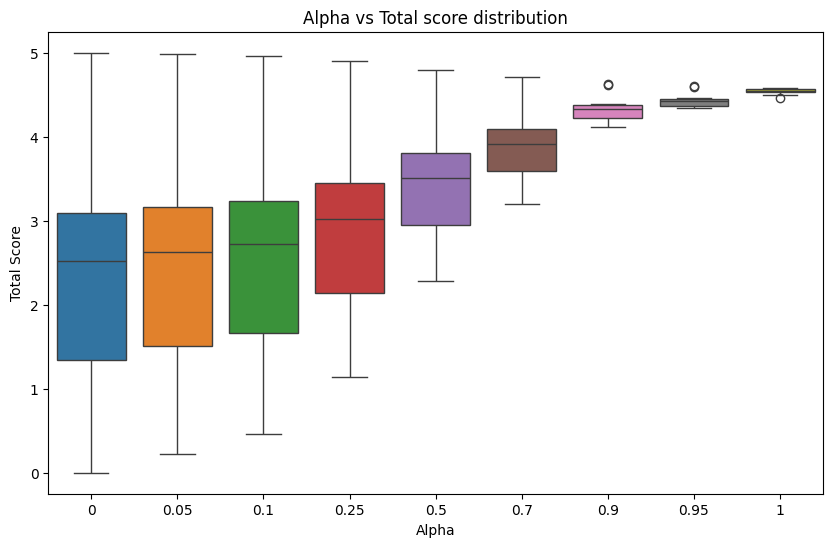

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

data = diversity_scores

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Use seaborn's boxplot function to plot each list as a separate distribution
sns.boxplot(data=data)

# Set plot labels and title
plt.xlabel('Alpha')
plt.ylabel('Total Score')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8], labels=[0, 0.05, 0.1, 0.25, 0.5, 0.7, 0.9, 0.95, 1])
plt.title('Alpha vs Total score distribution')

# Show the plot
plt.show()

In [26]:
import requests
import time

response_times = []

for i in range(0, 900):

    # Define the URL and parameters
    url = "http://localhost:5000/recommend?user_id={i}"
    # params = {"user_id": 780}  # Query parameters

    # Measure time taken for the request
    start_time = time.time()
    response = requests.get(url)
    end_time = time.time()

    elapsed_time = end_time - start_time

    response_times.append(elapsed_time)

Text(0.5, 1.0, 'Docker Recommendation Response Time Distribution')

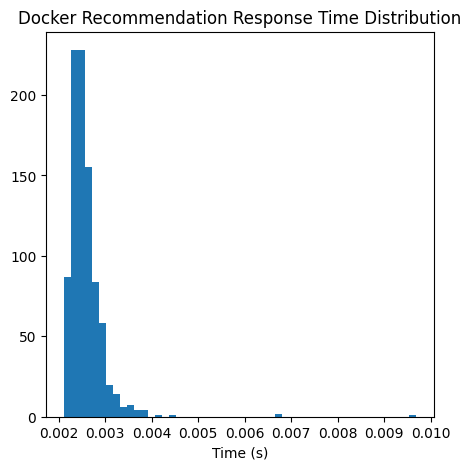

In [31]:

plt.figure(figsize = (5, 5))
plt.hist(response_times, bins = 50)
plt.xlabel('Time (s)')
plt.title('Docker Recommendation Response Time Distribution')